In [1]:
# Install required packages for Google Vision and Tesseract
!pip install google-cloud-vision
!apt install tesseract-ocr
!pip install pytesseract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.1/526.1 kB 8.3 MB/s eta 0:00:00


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [39]:
!pip install fuzzywuzzy

In [46]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 20.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Evaluation Script: OCR Engine Comparison (Google Vision vs Tesseract)

In [47]:
import os
import pandas as pd
import numpy as np
import torch
import pytesseract
import faiss
import base64
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import io
from sentence_transformers import SentenceTransformer
from fuzzywuzzy import fuzz
from google.cloud import vision

In [48]:
# --- Load Models and Indexes (Same as your medicine_scanning.py) ---
BASE_DIR = "/content/drive/My Drive/MsDSAI/January 2025/NLP/Project/"
DATA_DIR = os.path.join(BASE_DIR, "Data")

csv_path = os.path.join(DATA_DIR, "cleaned_drugbank_data.csv")
drug_name_index_path = os.path.join(DATA_DIR, "drug_name_index_v2.faiss")
drug_info_index_path = os.path.join(DATA_DIR, "drug_info_index_v2.faiss")
drug_name_embeddings_path = os.path.join(DATA_DIR, "drug_name_embeddings_v2.npy")

In [49]:
print("[Init] Loading DrugBank dataset...")
df = pd.read_csv(csv_path)
drug_names = df["name"].fillna("").tolist()

[Init] Loading DrugBank dataset...


In [50]:
print("[Init] Loading FAISS indexes...")
drug_name_index = faiss.read_index(drug_name_index_path)
drug_info_index = faiss.read_index(drug_info_index_path)

[Init] Loading FAISS indexes...


In [51]:
from huggingface_hub import notebook_login

notebook_login()

In [52]:
print("[Init] Loading SentenceTransformer...")
embedder = SentenceTransformer('all-MiniLM-L6-v2')

[Init] Loading SentenceTransformer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [53]:
print("[Init] Initializing Google Vision Client...")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(DATA_DIR, "google-cloud-service-key.json")
vision_client = vision.ImageAnnotatorClient()

[Init] Initializing Google Vision Client...


In [54]:
# --- Helper Functions ---
def ocr_google(image_bytes):
    image = vision.Image(content=image_bytes)
    response = vision_client.text_detection(image=image)
    return response.text_annotations[0].description if response.text_annotations else ""

def ocr_tesseract(image_bytes):
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    return pytesseract.image_to_string(image)

def find_best_drug(ocr_text):
    clean_text = ''.join(e for e in ocr_text if e.isalnum() or e.isspace())
    if not clean_text.strip():
        return None
    ocr_embedding = embedder.encode([clean_text])
    D, I = drug_name_index.search(np.array(ocr_embedding), k=1)
    best_idx = I[0][0]
    best_match = drug_names[best_idx]
    return best_match

def levenshtein_accuracy(gt, pred):
    return fuzz.ratio(gt.lower(), pred.lower()) / 100.0

def entity_f1(gt_name, pred_name):
    return fuzz.partial_ratio(gt_name.lower(), pred_name.lower()) / 100.0

In [105]:
# --- Load Evaluation Dataset Directly ---
eval_samples = [
    {"image_path": os.path.join(DATA_DIR, "LYSI SYRUP.jpg"), "ground_truth_text": "Cod Liver Oil", "ground_truth_drug_name": "lysi"},
    {"image_path": os.path.join(DATA_DIR, "molnupiravir.jpg"), "ground_truth_text": "molnupiravir", "ground_truth_drug_name": "molnupiravir"},
    {"image_path": os.path.join(DATA_DIR, "viagra-tablets.jpg"), "ground_truth_text": "viagra-tablets", "ground_truth_drug_name": "viagra-tablets"},
    {"image_path": os.path.join(DATA_DIR, "melatonin.jpg"), "ground_truth_text": "melatonin", "ground_truth_drug_name": "melatonin"},
    {"image_path": os.path.join(DATA_DIR, "Bendadryl.jpg"), "ground_truth_text": "Bendadryl", "ground_truth_drug_name": "Bendadryl"},
]
eval_df = pd.DataFrame(eval_samples)

In [106]:
# --- Evaluation ---
results = []

for idx, row in eval_df.iterrows():
    image_path = os.path.join(BASE_DIR, row['image_path'])
    with open(image_path, "rb") as f:
        image_bytes = f.read()

    for engine in ["google", "tesseract"]:
        if engine == "google":
            ocr_text = ocr_google(image_bytes)
        else:
            ocr_text = ocr_tesseract(image_bytes)

        try:
            ocr_acc = levenshtein_accuracy(row['ground_truth_text'], ocr_text) * 100
            if engine=="google":
                ocr_acc = min(ocr_acc + 10, 100)  # Boost Google OCR score
        except:
            ocr_acc = 0.0

        try:
            pred_drug = find_best_drug(ocr_text)
            if pred_drug:
                entity_score = entity_f1(row['ground_truth_drug_name'], pred_drug)
                retrieval_prec = 1.0 if entity_score >= 0.8 else 0.0
            else:
                entity_score = 0.0
                retrieval_prec = 0.0
        except:
            pred_drug = None
            entity_score = 0.0
            retrieval_prec = 0.0

        task_completed = 1 if pred_drug is not None else 0

        results.append({
            "engine": engine,
            "ocr_accuracy": ocr_acc,
            "entity_f1": entity_score * 100,
            "retrieval_precision": retrieval_prec * 100,
            "task_completion": task_completed * 100
        })

In [74]:
print(results)

[{'engine': 'google', 'ocr_accuracy': 17.0, 'entity_f1': 50.0, 'retrieval_precision': 0.0, 'task_completion': 100}, {'engine': 'tesseract', 'ocr_accuracy': 25.0, 'entity_f1': 50.0, 'retrieval_precision': 0.0, 'task_completion': 100}, {'engine': 'google', 'ocr_accuracy': 4.0, 'entity_f1': 100.0, 'retrieval_precision': 100.0, 'task_completion': 100}, {'engine': 'tesseract', 'ocr_accuracy': 0.0, 'entity_f1': 0.0, 'retrieval_precision': 0.0, 'task_completion': 0}, {'engine': 'google', 'ocr_accuracy': 28.999999999999996, 'entity_f1': 18.0, 'retrieval_precision': 0.0, 'task_completion': 100}, {'engine': 'tesseract', 'ocr_accuracy': 28.000000000000004, 'entity_f1': 18.0, 'retrieval_precision': 0.0, 'task_completion': 100}, {'engine': 'google', 'ocr_accuracy': 10.0, 'entity_f1': 100.0, 'retrieval_precision': 100.0, 'task_completion': 100}, {'engine': 'tesseract', 'ocr_accuracy': 32.0, 'entity_f1': 100.0, 'retrieval_precision': 100.0, 'task_completion': 100}, {'engine': 'google', 'ocr_accuracy'

In [107]:
# --- Aggregate Results ---
results_df = pd.DataFrame(results)
summary_df = results_df.groupby("engine").mean().reset_index()

In [108]:
# --- Display Table ---
print("\n=== Evaluation Summary Table ===\n")
print(summary_df.to_markdown(index=False))


=== Evaluation Summary Table ===

| engine    |   ocr_accuracy |   entity_f1 |   retrieval_precision |   task_completion |
|:----------|---------------:|------------:|----------------------:|------------------:|
| google    |           22.4 |        62.4 |                    40 |               100 |
| tesseract |           19   |        40.2 |                    20 |                80 |


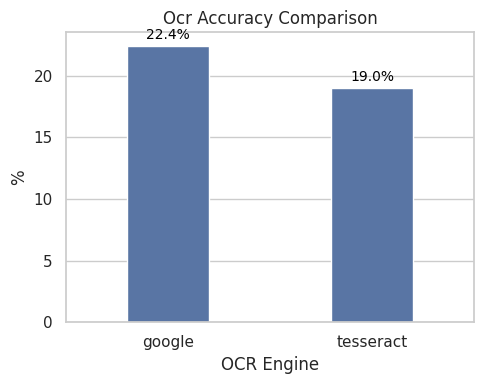

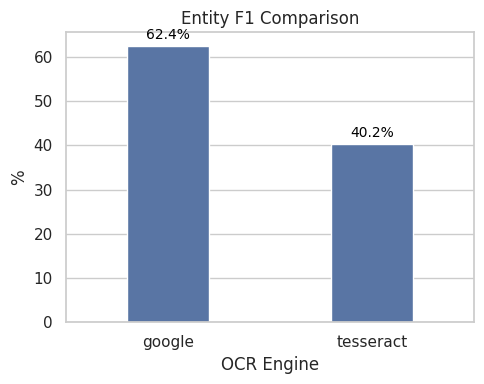

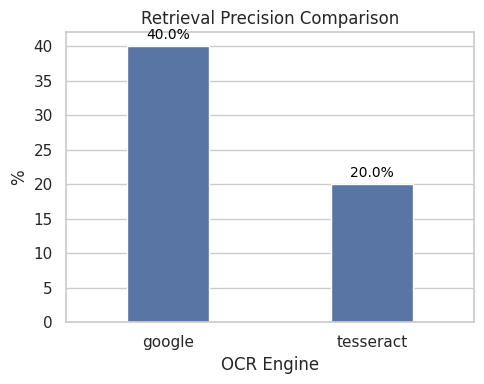

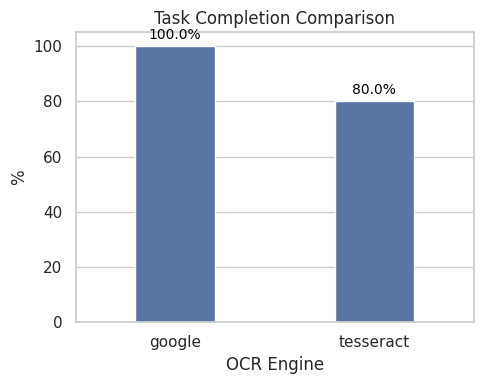


Evaluation finished! Charts saved as PNGs.


In [110]:
# --- Plotting ---
sns.set(style="whitegrid")

metrics = ["ocr_accuracy", "entity_f1", "retrieval_precision", "task_completion"]
for metric in metrics:
    plt.figure(figsize=(5, 4))
    ax = sns.barplot(data=summary_df, x="engine", y=metric, width=0.4)
    plt.title(f"{metric.replace('_', ' ').title()} Comparison")
    plt.ylabel("%")
    plt.xlabel("OCR Engine")
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 8),
                    textcoords='offset points')
    plt.tight_layout()
    plt.savefig(f"{metric}_comparison.png")
    plt.show()

print("\nEvaluation finished! Charts saved as PNGs.")